 # Training for ChessNN

### Imports

In [1]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
from tqdm import tqdm
from torch.cuda.amp import GradScaler, autocast
import matplotlib.pyplot as plt
import os
import sys


project_root = os.path.abspath(os.path.join(os.getcwd(), '../../'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src.engine.evaluators.simple_nn_eval import ChessNN  # Import the model class

### Load data and set configurations

In [2]:
# Configuration
DATA_PATH = '../../data/processed/lichess_eval/1.pt'  # From processing step
BATCH_SIZE = 256
EPOCHS = 50
LEARNING_RATE = 0.001
PATIENCE = 5  # For early stopping
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Load processed data
data = torch.load(DATA_PATH, map_location='cpu') # Ensure data is loaded to CPU
inputs = data['inputs']  # Shape: [num_samples, NUM_PLANES, 8, 8] - Keep on CPU
labels = data['labels']  # Shape: [num_samples, 1] - Keep on CPU
print(f"Loaded {len(inputs)} samples. Inputs shape: {inputs.shape}, Labels shape: {labels.shape}")

# Create dataset and split (80% train, 20% validation)
dataset = TensorDataset(inputs, labels)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

Using device: cuda
Loaded 1000000 samples. Inputs shape: torch.Size([1000000, 28, 8, 8]), Labels shape: torch.Size([1000000, 1])


### Setup

In [3]:

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=DEVICE.type == 'cuda')
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=DEVICE.type == 'cuda')

# Initialize model, loss, optimizer
model = ChessNN().to(DEVICE)
criterion = nn.MSELoss()  # Suitable for regression
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3)

scaler = GradScaler() if DEVICE.type == 'cuda' else None

/tmp/ipykernel_1006/2133279252.py:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() if DEVICE.type == 'cuda' else None


### Train function

In [4]:

# Training function with early stopping
def train_model():
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses, val_losses = [], []
    
    for epoch in range(EPOCHS):
        # Train
        model.train()
        train_loss = 0.0
        for batch_inputs, batch_labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} - Training"):
            batch_inputs = batch_inputs.to(DEVICE)
            batch_labels = batch_labels.to(DEVICE)

            optimizer.zero_grad()

            if scaler: # Use AMP if scaler is initialized (i.e., on CUDA)
                with autocast():
                    outputs = model(batch_inputs)
                    loss = criterion(outputs, batch_labels)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else: # Standard training path (CPU or no AMP)
                outputs = model(batch_inputs)
                loss = criterion(outputs, batch_labels)
                loss.backward()
                optimizer.step()
            
            train_loss += loss.item()
        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validate
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_inputs, batch_labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} - Validation"):
                batch_inputs = batch_inputs.to(DEVICE)
                batch_labels = batch_labels.to(DEVICE)
                
                if scaler: # Use autocast for consistency during validation if using AMP
                    with autocast():
                        outputs = model(batch_inputs)
                        loss = criterion(outputs, batch_labels)
                else:
                    outputs = model(batch_inputs)
                    loss = criterion(outputs, batch_labels)
                val_loss += loss.item()
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")
        scheduler.step(avg_val_loss)
        
        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_chess_nn.pth')
            print("Saved best model.")
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print("Early stopping triggered.")
                break
    
    # Plot losses
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

### Training

Epoch 1/50 - Training:   0%|          | 0/3125 [00:00<?, ?it/s]/tmp/ipykernel_1006/4251896696.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/50 - Validation:   0%|          | 0/782 [00:00<?, ?it/s]/tmp/ipykernel_1006/4251896696.py:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/50 - Validation: 100%|██████████| 782/782 [00:01<00:00, 421.16it/s]


Epoch 1: Train Loss = 0.0238, Val Loss = 0.0220
Saved best model.


Epoch 2/50 - Validation: 100%|██████████| 782/782 [00:01<00:00, 402.06it/s]


Epoch 2: Train Loss = 0.0201, Val Loss = 0.0194
Saved best model.


Epoch 3/50 - Validation: 100%|██████████| 782/782 [00:01<00:00, 400.31it/s]


Epoch 3: Train Loss = 0.0180, Val Loss = 0.0184
Saved best model.


Epoch 4/50 - Validation: 100%|██████████| 782/782 [00:01<00:00, 401.81it/s]


Epoch 4: Train Loss = 0.0163, Val Loss = 0.0185


Epoch 5/50 - Validation: 100%|██████████| 782/782 [00:01<00:00, 406.06it/s]


Epoch 5: Train Loss = 0.0148, Val Loss = 0.0168
Saved best model.


Epoch 6/50 - Validation: 100%|██████████| 782/782 [00:01<00:00, 416.13it/s]


Epoch 6: Train Loss = 0.0136, Val Loss = 0.0167
Saved best model.


Epoch 7/50 - Validation: 100%|██████████| 782/782 [00:01<00:00, 395.73it/s]


Epoch 7: Train Loss = 0.0125, Val Loss = 0.0163
Saved best model.


Epoch 8/50 - Validation: 100%|██████████| 782/782 [00:01<00:00, 404.69it/s]


Epoch 8: Train Loss = 0.0115, Val Loss = 0.0165


Epoch 9/50 - Validation: 100%|██████████| 782/782 [00:01<00:00, 414.88it/s]


Epoch 9: Train Loss = 0.0108, Val Loss = 0.0164


Epoch 10/50 - Validation: 100%|██████████| 782/782 [00:02<00:00, 375.42it/s]


Epoch 10: Train Loss = 0.0101, Val Loss = 0.0165


Epoch 11/50 - Validation: 100%|██████████| 782/782 [00:02<00:00, 375.10it/s]


Epoch 11: Train Loss = 0.0095, Val Loss = 0.0162
Saved best model.


Epoch 12/50 - Validation: 100%|██████████| 782/782 [00:01<00:00, 399.38it/s]


Epoch 12: Train Loss = 0.0090, Val Loss = 0.0166


Epoch 13/50 - Validation: 100%|██████████| 782/782 [00:01<00:00, 406.09it/s]


Epoch 13: Train Loss = 0.0086, Val Loss = 0.0173


Epoch 14/50 - Validation: 100%|██████████| 782/782 [00:01<00:00, 396.47it/s]


Epoch 14: Train Loss = 0.0082, Val Loss = 0.0164


Epoch 15/50 - Validation: 100%|██████████| 782/782 [00:02<00:00, 268.06it/s]


Epoch 15: Train Loss = 0.0079, Val Loss = 0.0169


Epoch 16/50 - Validation: 100%|██████████| 782/782 [00:02<00:00, 372.34it/s]


Epoch 16: Train Loss = 0.0062, Val Loss = 0.0156
Saved best model.


Epoch 17/50 - Validation: 100%|██████████| 782/782 [00:01<00:00, 400.72it/s]


Epoch 17: Train Loss = 0.0056, Val Loss = 0.0156
Saved best model.


Epoch 18/50 - Validation: 100%|██████████| 782/782 [00:01<00:00, 398.83it/s]


Epoch 18: Train Loss = 0.0053, Val Loss = 0.0157


Epoch 19/50 - Validation: 100%|██████████| 782/782 [00:02<00:00, 383.46it/s]


Epoch 19: Train Loss = 0.0051, Val Loss = 0.0157


Epoch 20/50 - Validation: 100%|██████████| 782/782 [00:02<00:00, 376.21it/s]


Epoch 20: Train Loss = 0.0050, Val Loss = 0.0158


Epoch 21/50 - Validation: 100%|██████████| 782/782 [00:01<00:00, 397.06it/s]


Epoch 21: Train Loss = 0.0048, Val Loss = 0.0158


Epoch 22/50 - Validation: 100%|██████████| 782/782 [00:01<00:00, 400.02it/s]


Epoch 22: Train Loss = 0.0046, Val Loss = 0.0158
Early stopping triggered.


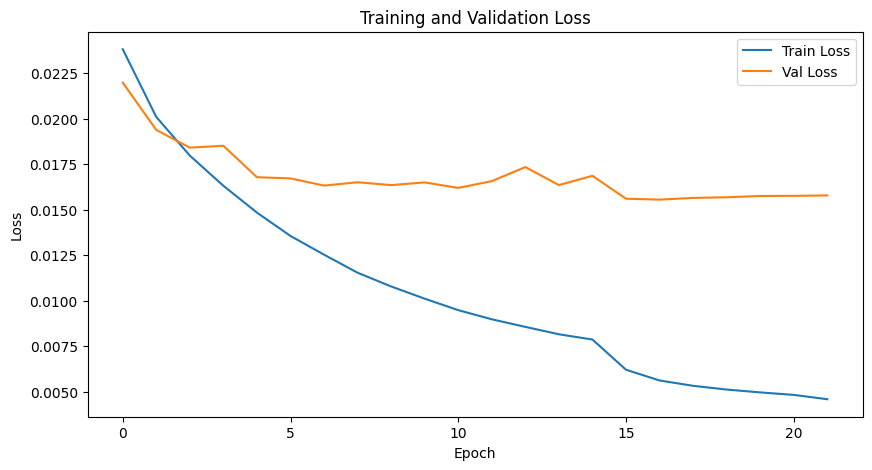

In [5]:
train_model()